# Calc Geostrophic Velocity Between Stations

- EPIC tool on iris3?
- wrt bottom (or common deepest value) vs wrt to surface

- seawater vs gsw

In [624]:
import pandas as pd
import numpy as np
import seawater
import gsw
import cmocean

In [625]:
cruiseid='dy2013'
dfo = pd.read_csv('data/CTD_'+cruiseid+'.csv')


In [626]:
dfg = dfo.groupby('profile_id')
dfg.groups.keys()

dict_keys(['dy2012_ctd036', 'dy2012_ctd037', 'dy2012_ctd039', 'dy2012_ctd040', 'dy2012_ctd041', 'dy2012_ctd042', 'dy2012_ctd043'])

In [627]:
geovel_colnames = ["{}-{}".format(b_, a_) for a_, b_ in zip(list(dfg.groups.keys())[1:],list(dfg.groups.keys())[:-1])]
geovel_colnames

['dy2012_ctd036-dy2012_ctd037',
 'dy2012_ctd037-dy2012_ctd039',
 'dy2012_ctd039-dy2012_ctd040',
 'dy2012_ctd040-dy2012_ctd041',
 'dy2012_ctd041-dy2012_ctd042',
 'dy2012_ctd042-dy2012_ctd043']

In [628]:
df = dfo

In [629]:
df_salt = pd.pivot_table(df,'S_41 (PSU)','pressure (dbar)','profile_id')
df_temp = pd.pivot_table(df,'T_28 (degree_C)','pressure (dbar)','profile_id')
dflat = pd.pivot_table(df,'latitude (degrees_north)','pressure (dbar)','profile_id')
dflon = pd.pivot_table(df,'longitude (degrees_east)','pressure (dbar)','profile_id')

reverse = False
if reverse:
    df_salt=df_salt[df_salt.columns[::-1]]
    df_temp=df_temp[df_temp.columns[::-1]]
    dflat=dflat[dflat.columns[::-1]]
    dflon=dflon[dflon.columns[::-1]]
    
    

In [630]:
gpan = seawater.gpan(df_salt.values,df_temp.values,df_salt.index.values.reshape(len(df_salt.index.values),1))
#same as gsw iteration below

In [631]:
gvel = seawater.gvel(gpan,dflat.iloc[10].values,dflon.iloc[10].values)

In [632]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [633]:
gvel_df = pd.DataFrame(gvel,columns=geovel_colnames)

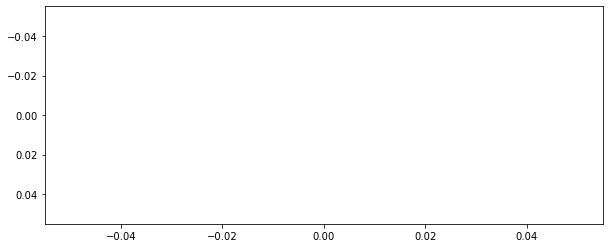

In [634]:
fig, ax = plt.subplots(figsize=(10, 4))
ax = plt.plot(gvel_df,gvel_df.index)
plt.gca().invert_yaxis()

In [635]:
df_SA = gsw.SA_from_SP(df_salt.values,df_salt.index.values.reshape(len(df_salt.index.values),1),dflon.iloc[10].values,dflat.iloc[10].values)
df_CT = gsw.CT_from_t(df_SA,df_temp.values,df_salt.index.values.reshape(len(df_salt.index.values),1))

gswpan = gsw.geo_strf_dyn_height(df_SA,df_CT,df_salt.index.values.reshape(len(df_salt.index.values),1),axis=0,p_ref=df_salt.dropna(how='any').index.max())

df_salt.dropna(how='any').index

gswvel = gsw.geostrophy.geostrophic_velocity(gswpan,dflon.iloc[10].values,dflat.iloc[10].values,p=df_salt.dropna(how='any').index.max(),axis=0)



In [636]:
df_SA = gsw.SA_from_SP(df_salt.values,df_salt.index.values.reshape(len(df_salt.index.values),1),dflon.iloc[10].values,dflat.iloc[10].values)
df_CT = gsw.CT_from_t(df_SA,df_temp.values,df_salt.index.values.reshape(len(df_salt.index.values),1))

gswpan = gsw.geo_strf_dyn_height(df_SA,df_CT,df_salt.index.values.reshape(len(df_salt.index.values),1),axis=0,p_ref=df_salt.dropna(how='any').index.max())

gswvel = gsw.geostrophy.geostrophic_velocity(gswpan,dflon.iloc[10].values,dflat.iloc[10].values,p=df_salt.dropna(how='any').index.max(),axis=0)


gswvel_df = pd.DataFrame(gswvel[0],columns=geovel_colnames)

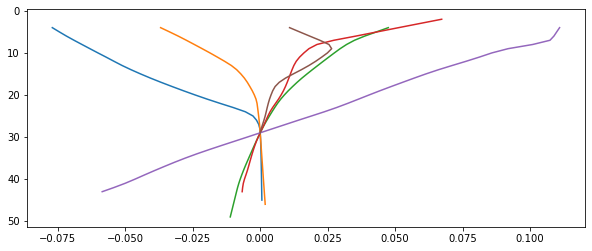

In [637]:
fig, ax = plt.subplots(figsize=(10, 4))
ax = plt.plot(gswvel_df,gswvel_df.index)
plt.gca().invert_yaxis()

In [638]:
alongx=gsw.geostrophy.distance(dflon.iloc[10].values,dflat.iloc[10].values)
alongx

array([19107.89974672, 19861.29532041, 19638.12576116, 20869.91585106,
       10247.87580361, 19758.1822027 ])

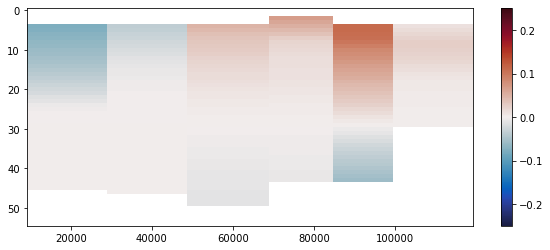

In [639]:
fig, ax = plt.subplots(figsize=(10, 4))
ax = plt.pcolormesh(alongx.cumsum(),gswvel_df.index,gswvel_df,shading='nearest', vmin=-.25, vmax=.25,cmap=cmocean.cm.balance)
plt.gca().invert_yaxis()
plt.colorbar()

In [640]:
gswvel_df.to_csv(cruiseid+'.geovel.csv')
print(alongx.cumsum())

[ 19107.89974672  38969.19506713  58607.32082829  79477.23667935
  89725.11248296 109483.29468566]
